In [11]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import networkx as nx
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

# Import the mis function from the util module in the parent folder
from util import mis, generate_run_name

class GraphEnvironment(gym.Env):
    def __init__(self, max_nodes=10):
        super(GraphEnvironment, self).__init__()
        self.max_nodes = max_nodes
        self.action_space = spaces.Discrete(max_nodes * (max_nodes - 1) // 2 + 1)  # All possible edges + termination action
        self.observation_space = spaces.Box(low=0, high=1, shape=(max_nodes, max_nodes), dtype=np.int8)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.G = nx.Graph()
        self.G.add_node(0)  # Start with one node
        self.step_count = 0
        return self._get_observation(), {}  # Return observation and an empty info dict

    def step(self, action):
        self.step_count += 1
        terminated = False
        truncated = False
        
        if action == self.action_space.n - 1 or self.step_count >= self.max_nodes * (self.max_nodes - 1) // 4:
            # Termination action or max steps reached
            terminated = True
        else:
            # Add an edge
            source = int(np.floor(np.sqrt(2 * action + 0.25) - 0.5))
            target = int(action - source * (source + 1) // 2)
            if source not in self.G.nodes():
                self.G.add_node(source)
            if target not in self.G.nodes():
                self.G.add_node(target)
            if not self.G.has_edge(source, target):
                self.G.add_edge(source, target)

        observation = self._get_observation()
        reward = self._calculate_reward() if terminated else 0
        info = {}

        return observation, reward, terminated, truncated, info

    def _get_observation(self):
        adj_matrix = nx.to_numpy_array(self.G)
        padded_matrix = np.zeros((self.max_nodes, self.max_nodes), dtype=np.int8)
        padded_matrix[:adj_matrix.shape[0], :adj_matrix.shape[1]] = adj_matrix
        return padded_matrix

    def _count_steps(self):
        def count_steps_recursive(G):
            step_counts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
            
            def recursive_mis(G):
                step_counts[1] += 1
                if len(G) == 0:
                    return set()
                
                degrees = dict(G.degree())
                if not degrees:  # Check if degrees is empty
                    return set()
                
                if max(degrees.values()) <= 2:
                    step_counts[2] += 1
                    return set()  # We don't actually need to compute the MIS
                
                step_counts[3] += 1
                degree_one_nodes = [n for n, d in degrees.items() if d == 1]
                if degree_one_nodes:
                    step_counts[4] += 1
                    v = degree_one_nodes[0]
                    recursive_mis(G.subgraph(set(G.nodes()) - set(G.neighbors(v)) - {v}))
                    return
                
                step_counts[5] += 1
                if not nx.is_connected(G):
                    step_counts[6] += 1
                    components = list(nx.connected_components(G))
                    G1 = G.subgraph(components[0])
                    step_counts[7] += 1
                    recursive_mis(G1)
                    recursive_mis(G.subgraph(set(G.nodes()) - set(G1.nodes())))
                    return
                
                step_counts[8] += 1
                step_counts[9] += 1
                max_degree_node = max(degrees, key=degrees.get)
                step_counts[10] += 1
                recursive_mis(G.subgraph(set(G.nodes()) - set(G.neighbors(max_degree_node)) - {max_degree_node}))
                recursive_mis(G.subgraph(set(G.nodes()) - {max_degree_node}))
            
            recursive_mis(G)
            return step_counts

        return count_steps_recursive(self.G)

    def _calculate_reward(self):
        step_counts = self._count_steps()
        line_10_calls = step_counts[10]
        total_steps = sum(step_counts.values())
        return line_10_calls / max(total_steps, 1)  # Reward is the proportion of line 10 calls

    def render(self):
        plt.figure(figsize=(8, 6))
        nx.draw(self.G, with_labels=True, node_color='lightblue', node_size=500, font_size=16, font_weight='bold')
        plt.title(f"Generated Graph (Nodes: {self.G.number_of_nodes()}, Edges: {self.G.number_of_edges()})")
        plt.show()

def evaluate_agent(model, env, num_episodes=5):
    for i in range(num_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
        
        print(f"Episode {i+1}")
        env.render()
        run_name = generate_run_name(env.G)
        mis_result = mis(env.G, visualize=True, verbose=True, run_name=run_name)
        step_counts = env._count_steps()  # Now we use _count_steps() instead of _calculate_reward()
        print(f"MIS size: {len(mis_result)}")
        print(f"Line 10 calls: {step_counts[10]}")
        print(f"Total steps: {sum(step_counts.values())}")
        print(f"Proportion of line 10 calls: {step_counts[10] / sum(step_counts.values()):.2f}")
        print("--------------------")


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 6982 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 4789        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010307337 |
|    clip_fraction        | 0.0648      |
|    clip_range           | 0.2         |
|    entropy_loss         | -3.82       |
|    explained_variance   | -4.1385384  |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0755     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0379     |
|    value_loss           | 0.0163      |
-----------------------------------------
-----------------

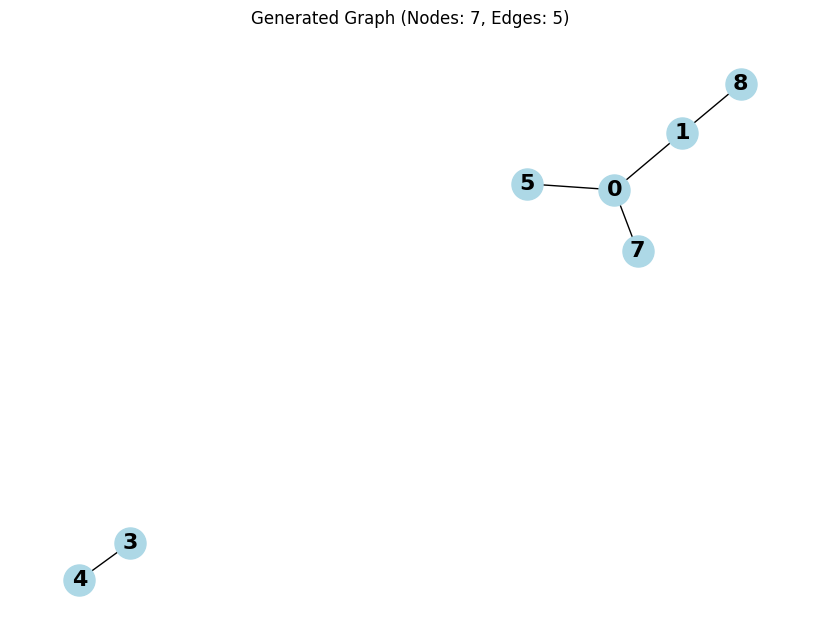

Step 1: Executing line 1 (Depth: 0)
Step 2: Executing line 3 (Depth: 0)
Step 3: Executing line 4 (Depth: 0)
Step 4: Executing line 1 (Depth: 1)
Step 5: Executing line 2 (Depth: 1)

Step counts:
Line 1: 2 times
Line 3: 1 times
Line 4: 1 times
Line 2: 1 times
Total steps: 5
MIS size: 4
Line 10 calls: 0
Total steps: 5
Proportion of line 10 calls: 0.00
--------------------
Episode 2


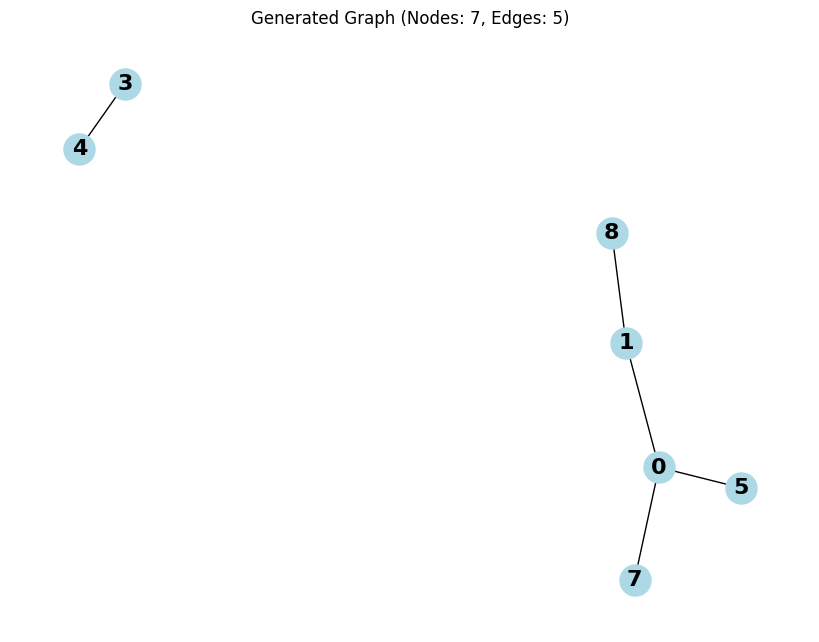

Step 1: Executing line 1 (Depth: 0)
Step 2: Executing line 3 (Depth: 0)
Step 3: Executing line 4 (Depth: 0)
Step 4: Executing line 1 (Depth: 1)
Step 5: Executing line 2 (Depth: 1)

Step counts:
Line 1: 2 times
Line 3: 1 times
Line 4: 1 times
Line 2: 1 times
Total steps: 5
MIS size: 4
Line 10 calls: 0
Total steps: 5
Proportion of line 10 calls: 0.00
--------------------
Episode 3


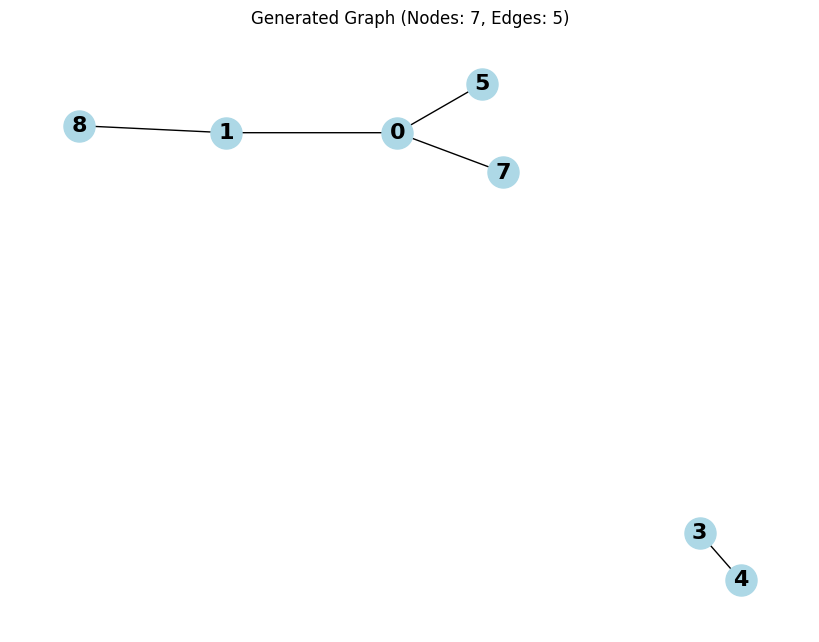

Step 1: Executing line 1 (Depth: 0)
Step 2: Executing line 3 (Depth: 0)
Step 3: Executing line 4 (Depth: 0)
Step 4: Executing line 1 (Depth: 1)
Step 5: Executing line 2 (Depth: 1)

Step counts:
Line 1: 2 times
Line 3: 1 times
Line 4: 1 times
Line 2: 1 times
Total steps: 5
MIS size: 4
Line 10 calls: 0
Total steps: 5
Proportion of line 10 calls: 0.00
--------------------
Episode 4


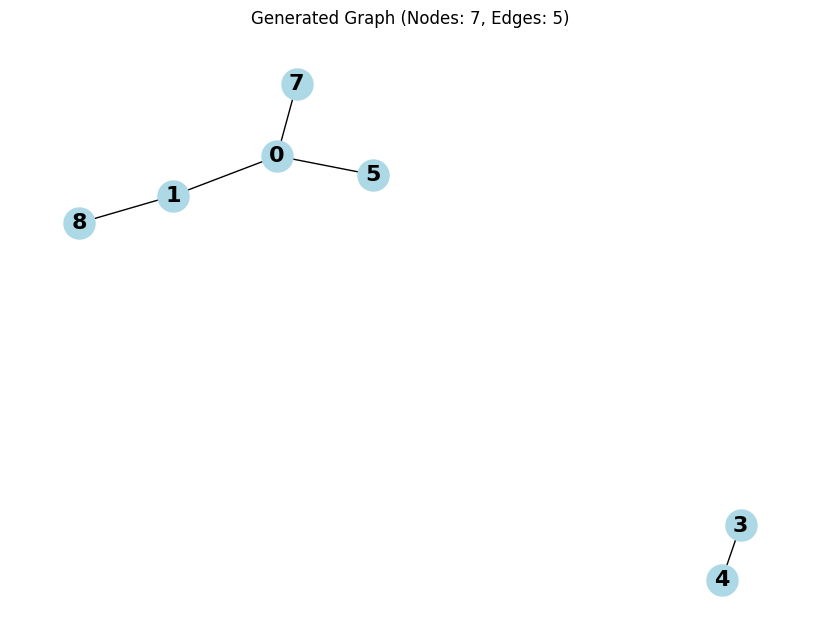

Step 1: Executing line 1 (Depth: 0)
Step 2: Executing line 3 (Depth: 0)
Step 3: Executing line 4 (Depth: 0)
Step 4: Executing line 1 (Depth: 1)
Step 5: Executing line 2 (Depth: 1)

Step counts:
Line 1: 2 times
Line 3: 1 times
Line 4: 1 times
Line 2: 1 times
Total steps: 5
MIS size: 4
Line 10 calls: 0
Total steps: 5
Proportion of line 10 calls: 0.00
--------------------
Episode 5


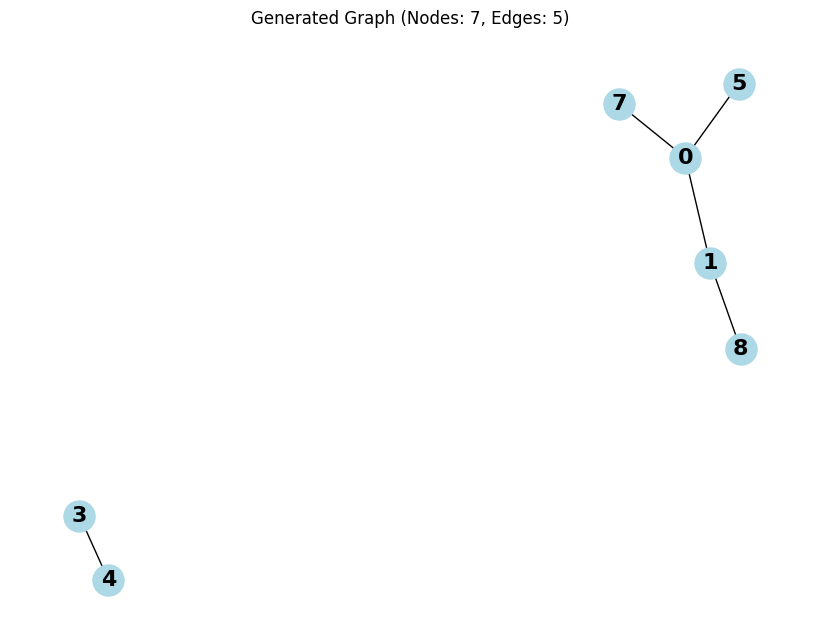

Step 1: Executing line 1 (Depth: 0)
Step 2: Executing line 3 (Depth: 0)
Step 3: Executing line 4 (Depth: 0)
Step 4: Executing line 1 (Depth: 1)
Step 5: Executing line 2 (Depth: 1)

Step counts:
Line 1: 2 times
Line 3: 1 times
Line 4: 1 times
Line 2: 1 times
Total steps: 5
MIS size: 4
Line 10 calls: 0
Total steps: 5
Proportion of line 10 calls: 0.00
--------------------


In [12]:

# Create and wrap the environment
env = DummyVecEnv([lambda: GraphEnvironment(max_nodes=10)])

# Initialize the agent
model = PPO("MlpPolicy", env, verbose=1)

# Train the agent
model.learn(total_timesteps=100000)

# Evaluate the agent
evaluate_agent(model, env.envs[0])

# Save the trained model
model.save("graph_generation_model")

# To load the model later, you can use:
# model = PPO.load("graph_generation_model")